This notebook deals with the contents of Section 5.3 of the book.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from cmdstanpy import CmdStanModel
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Load and inspect data

In [2]:
df = pd.read_csv("data/data-attendance-3.txt")
print(len(df))
print(df.dtypes)
df.head(5)

2396
PersonID     int64
A            int64
Score        int64
Weather     object
Y            int64
dtype: object


,PersonID,A,Score,Weather,Y
0,1,0,69,B,1
1,1,0,69,A,1
2,1,0,69,C,1
3,1,0,69,A,1
4,1,0,69,B,1


In [3]:
pd.crosstab(df["Weather"], df["Y"])

Y,0,1
Weather,,
A,306,953
B,230,500
C,138,269


In [4]:
# exercise (3)
pd.crosstab(df["A"], df["Y"])

Y,0,1
A,,
0,288,994
1,386,728


# Run Stan

In [5]:
model = CmdStanModel(stan_file="model/model5-5.stan")
print(model)

INFO:cmdstanpy:compiling stan program, exe file: /workdir/chapter05/model/model5-5
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /workdir/chapter05/model/model5-5


CmdStanModel: name=model5-5
	 stan_file=/workdir/chapter05/model/model5-5.stan
	 exe_file=/workdir/chapter05/model/model5-5
	 compiler_optons=stanc_options=None, cpp_options=None


In [6]:
def weather_to_float(weather):
    if weather == 'A':
        return 0.0
    elif weather =='B':
        return 0.2
    elif weather == 'C':
        return 1.0

In [7]:
data = {
    "I" : len(df),
    "A" : df["A"].values,
    "Score" : df["Score"].values/200,
    "W" : np.vectorize(weather_to_float)(df["Weather"].values),
    "Y" : df["Y"].values
}

In [8]:
fit = model.sample(data=data)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 2


# Inspect the result

In [9]:
print(type(fit))
print(fit)

<class 'cmdstanpy.stanfit.CmdStanMCMC'>
CmdStanMCMC: model=model5-5 chains=4['method=sample', 'algorithm=hmc', 'adapt', 'engaged=1']
 csv_files:
	/tmp/tmp958ba7mn/model5-5-202010271135-1-0iwmsgvo.csv
	/tmp/tmp958ba7mn/model5-5-202010271135-2-d_kdw72_.csv
	/tmp/tmp958ba7mn/model5-5-202010271135-3-pzrg9gwx.csv
	/tmp/tmp958ba7mn/model5-5-202010271135-4-l4mmeep3.csv
 output_files:
	/tmp/tmp958ba7mn/model5-5-202010271135-1-0iwmsgvo-stdout.txt
	/tmp/tmp958ba7mn/model5-5-202010271135-2-d_kdw72_-stdout.txt
	/tmp/tmp958ba7mn/model5-5-202010271135-3-pzrg9gwx-stdout.txt
	/tmp/tmp958ba7mn/model5-5-202010271135-4-l4mmeep3-stdout.txt


In [10]:
print(fit.num_draws)
print(fit.draws().shape)

1000
(1000, 4, 2407)


In [11]:
fit.stan_variables()

{'b': array([[ 0.282188 , -0.648919 ,  1.93711  , -0.543485 ],
        [ 0.202322 , -0.638753 ,  1.86807  , -0.527714 ],
        [ 0.189609 , -0.63699  ,  1.84776  , -0.532769 ],
        ...,
        [-0.0416055, -0.484257 ,  2.19281  , -0.267453 ],
        [ 0.0506004, -0.593092 ,  2.02166  , -0.355543 ],
        [-0.0470418, -0.700027 ,  2.50268  , -0.406867 ]]),
 'q': array([[0.698843, 0.721214, 0.60037 , ..., 0.643856, 0.512161, 0.512161],
        [0.677272, 0.699896, 0.579103, ..., 0.619697, 0.490138, 0.490138],
        [0.672724, 0.695739, 0.573053, ..., 0.614735, 0.483629, 0.483629],
        ...,
        [0.65958 , 0.671486, 0.610036, ..., 0.636355, 0.572517, 0.572517],
        [0.663061, 0.678758, 0.596891, ..., 0.612594, 0.525649, 0.525649],
        [0.675904, 0.693468, 0.600972, ..., 0.620521, 0.52121 , 0.52121 ]])}

In [12]:
fit_summary = fit.summary()
fit_summary

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-1383.04,0.035083,1.40578,-1385.80,-1382.71,-1381.42,1605.66,35.4708,1.00167
b[1],0.16,0.004900,0.22000,-0.19,0.16,0.53,1959.00,43.0000,1.00000
b[2],-0.62,0.001700,0.09100,-0.77,-0.62,-0.47,2760.00,61.0000,1.00000
b[3],2.00,0.007800,0.35000,1.40,2.00,2.50,1995.00,44.0000,1.00000
b[4],-0.46,0.002500,0.13000,-0.67,-0.46,-0.26,2600.00,57.0000,1.00000
...,...,...,...,...,...,...,...,...,...
q[2392],0.60,0.000340,0.01800,0.57,0.60,0.63,2769.00,61.0000,1.00000
q[2393],0.63,0.000370,0.01900,0.60,0.63,0.66,2575.00,57.0000,1.00000
q[2394],0.63,0.000370,0.01900,0.60,0.63,0.66,2575.00,57.0000,1.00000


In [13]:
# Check the convergence
fit_summary[fit_summary["R_hat"] >= 1.1]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,


In [14]:
print(fit.diagnose())

INFO:cmdstanpy:Processing csv files: /tmp/tmp958ba7mn/model5-5-202010271135-1-0iwmsgvo.csv, /tmp/tmp958ba7mn/model5-5-202010271135-2-d_kdw72_.csv, /tmp/tmp958ba7mn/model5-5-202010271135-3-pzrg9gwx.csv, /tmp/tmp958ba7mn/model5-5-202010271135-4-l4mmeep3.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory for all transitions.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.


Processing csv files: /tmp/tmp958ba7mn/model5-5-202010271135-1-0iwmsgvo.csv, /tmp/tmp958ba7mn/model5-5-202010271135-2-d_kdw72_.csv, /tmp/tmp958ba7mn/model5-5-202010271135-3-pzrg9gwx.csv, /tmp/tmp958ba7mn/model5-5-202010271135-4-l4mmeep3.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory for all transitions.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.


# Plot the result

In [15]:
q_percentiles = np.percentile(fit.stan_variable("q"), [10.0, 50.0, 90.0], axis=0)
q_percentiles.shape

(3, 2396)

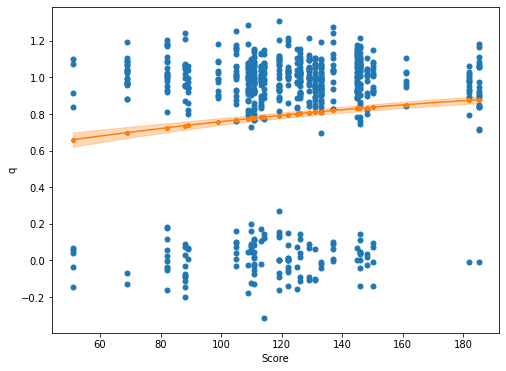

In [16]:
# Fig 5.9
# Plot score vs q (for weather = 'A' and 'A' = 0 only)

df_tmp = df.sort_values(by=["Score"])[["Weather", "A"]]
idx = df_tmp[(df_tmp["Weather"] == 'A') & (df_tmp['A'] == 0)].index.values

fig = plt.figure(figsize=(8, 6))
ax = plt.subplot(111)

ax.plot(df["Score"][idx], df["Y"][idx] + 0.1*np.random.randn(len(idx)), 'o', markersize=5, color="C0")
ax.plot(df["Score"][idx], q_percentiles[1][idx], '.-', color="C1")
ax.fill_between(df["Score"][idx], q_percentiles[0][idx], q_percentiles[2][idx], alpha=0.3, color="C1")
ax.set_xlabel("Score")
ax.set_ylabel("q")
fig.show()

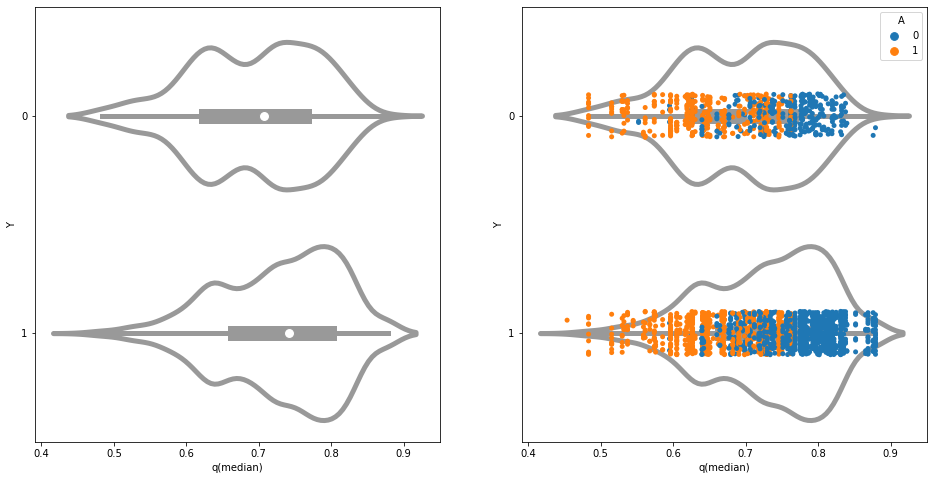

In [17]:
# Fig 5.10
# prob vs. observation

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

ax = axes[0]
sns.violinplot(x=q_percentiles[1], y=df["Y"], color='white', linewidth=5, orient='h', ax=ax)
ax.set_xlabel("q(median)")

ax = axes[1]
sns.violinplot(x=q_percentiles[1], y=df["Y"], color='white', linewidth=5, orient='h', ax=ax)
sns.stripplot(x=q_percentiles[1], y=df["Y"], hue=df["A"], orient='h', ax=ax)
ax.set_xlabel("q(median)")

fig.show()

ROC AUC Score : 0.6173463848881813


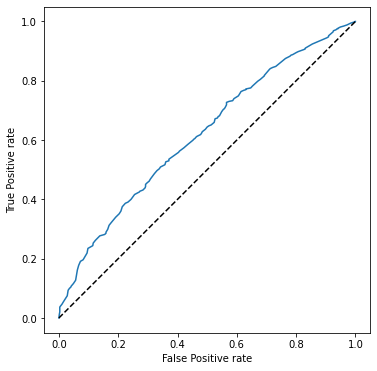

In [18]:
# Fig 5.11
# ROC curve : 

print("ROC AUC Score :", roc_auc_score(df["Y"].values, q_percentiles[1]))

fpr, tpr, thresholds = roc_curve(df["Y"].values, q_percentiles[1])
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.plot(fpr, tpr)
ax.plot([0,1], [0,1], 'k--')
ax.set_aspect("equal")
ax.set_xlabel("False Positive rate")
ax.set_ylabel("True Positive rate")
fig.show()